In [76]:
using CollectiveSpins
using QuantumOptics
using PyPlot
using LinearAlgebra
using JLD2
using Statistics

In [77]:
""" Compute the spin exchange hamiltonian """
function compute_H_SE(N, bMB, Ω_CSC, σp, σm)
    H = SparseOperator(bMB)
    
    for i=1:N, j=1:N
        if i==j
            continue
        end
        σp_MB_i = embed(bMB, i, σp)
        σm_MB_j = embed(bMB, j, σm)
        
        H += Ω_CSC[i, j] * σp_MB_i*σm_MB_j
    end
    return H
end

""" Compute the atomic hamiltonian in a harmonic centered trap"""
function compute_Hat_HT(Nx, Ny, Nz, bMB, ω0lat, d_xy, d_z, σz)
    H = SparseOperator(bMB)
    Matidx = reshape([1:N;], Nx, Ny, Nz)
    for i=1:N
        idx = findall(x->x==i, Matidx)[1]
        x, y, z = idx[1], idx[2], idx[3]
        # Compute the normalised distance from the center of the trap
        d = sqrt((x-1 - (Nx-1)/2)^2 + (y-1 - (Ny-1)/2)^2 + (z-1 - (Nz-1)/2)^2)
        #println(d)
        H += ω0lat * d^2 * embed(bMB, i, σp)*embed(bMB, i, σm)
    end
    return H
end

""" Return H_ZZ for the spin collection S """
function compute_H_ZZ(Nx, Ny, Nz, bMB, Ω_ZZ_coeff)
    H = SparseOperator(bMB)
    Matidx = reshape([1:N;], Nx, Ny, Nz)
    
    for i=1:N
        idx = findall(x->x==i, Matidx)[1]
        x, y, z = idx[1], idx[2], idx[3]

        # Neighbourg displacment
        neighbors = [
        (1, 0, 0), (-1, 0, 0),
        (0, 1, 0), (0, -1, 0),
        (0, 0, 1), (0, 0, -1)
        ]

        for (dx, dy, dz) in neighbors
            xj, yj, zj = x + dx, y + dy, z + dz
            # Check if neighbours are on the lattice
            if 1 <= xj <= Nx && 1 <= yj <= Ny && 1 <= zj <= Nz
                j = LinearIndices((Nx, Ny, Nz))[xj, yj, zj]

                #println(string(i)*"["*string(x)*", "*string(y)*", "*string(z)*"], "*string(j)*"["*string(xj)*", "*string(yj)*", "*string(zj)*"]")

                H += (Ω_ZZ_coeff[1] * embed(bMB, i, σp*σm)*embed(bMB, j, σp*σm) + 
                    Ω_ZZ_coeff[2] * (embed(bMB, i, σp*σm)*embed(bMB, j, σm*σp) + embed(bMB, i, σm*σp)*embed(bMB, j, σp*σm)) + 
                    Ω_ZZ_coeff[3] * embed(bMB, i, σm*σp)*embed(bMB, j, σm*σp))
            end
        end
    end
    return H
end

""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array)
    phi_array = zeros(N)
    for i = 1:N
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2))
    end
    return phi_array
end

prepare_phi_IS

### Define the system

In [ ]:
# Define geometry of system
Nx,Ny,Nz = [2,2,2]
N = Nx*Ny*Nz
d_xy, d_z = 266., 532. # Optical lattice spacing in nm
e = [0,0,1]   # Quantization axis
Γ0 = 1. # In Hz

theta_init = pi/2
phi_init = 1

θl = 0. # Angle of the laser
λ = 1299.

a,b,c = [d_xy,d_xy,d_z]/λ
geo = geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
system = SpinCollection(geo, e, gammas=1.)

Ω_ZZ_coeff = [53, 42, 33]./Γ0

# Lattice frequency
ω0lat = 1e-1 # Normalised by Γ0

Tstep, Tend = 1e-3, 1 # Normalised by Γ0
T = [0:Tstep:Tend;];

In [79]:
Ω_CS = CollectiveSpins.interaction.OmegaMatrix(system)./Γ0
Γ_CS = CollectiveSpins.interaction.GammaMatrix(system)./Γ0;

### Operators/basis

In [80]:
# Define Spin basis/operators
b1 = SpinBasis(1//2)
bMB = CompositeBasis([b1 for i=1:N])

# Single atom operators
I1 = identityoperator(b1)
IMB = identityoperator(bMB)
σx = sigmax(b1)
σy = sigmay(b1)
σz = sigmaz(b1)
σm = sigmam(b1)
σp = sigmap(b1)
σz67 = -σz/2 - 6.5*I1

# Many-body operators
Jx = sum([embed(bMB, i, σx) for i = 1:N])
Jy = sum([embed(bMB, i, σy) for i = 1:N])
Jz67 = sum([embed(bMB, i, σz67) for i = 1:N])

# Hamiltonian
HSF = compute_H_SE(N, bMB, Ω_CS, σp, σm)
Hat = compute_Hat_HT(Nx, Ny, Nz, bMB, ω0lat, d_xy, d_z, σz67)
HZZ = compute_H_ZZ(Nx, Ny, Nz, bMB, Ω_ZZ_coeff)

# Jump operators
J = [embed(bMB, i, σm) for i = 1:N];

### Computations

In [81]:
theta_array = ones(N)*theta_init
phi_array = prepare_phi_IS(θl, λ, theta_array)*phi_init
Ψ0 = CollectiveSpins.quantum.blochstate(phi_array, theta_array)
tout, ρt = timeevolution.master(T, Ψ0, HSF+Hat+HZZ, J, rates=Γ_CS, dt=Tstep);

In [82]:
# In the HT
mean_σx = [real(expect(Jx, ρ))./N for ρ in ρt]
mean_σy = [real(expect(Jy, ρ))./N for ρ in ρt]
mean_σz = [real(expect(Jz67, ρ))./N for ρ in ρt]
σx_array = [[real(expect(embed(bMB, i, σx), ρ)) for i = 1:N] for ρ in ρt]
σy_array = [[real(expect(embed(bMB, i, σy), ρ)) for i = 1:N] for ρ in ρt]
σz_array = [[real(expect(embed(bMB, i, σz67), ρ)) for i = 1:N] for ρ in ρt];

### QC C functions

In [83]:
@load "Sol_QC_Nx_$(Nx)_Ny_$(Ny)_Nz_$(Nz)_theta_$(round(theta_init, digits=1))_phi_$(phi_init)_HT_$(ω0lat)" sol;

In [84]:
mean_σx_QC = [2*mean(real(sol[i][N+1:2*N])) for i=1:length(T)]
mean_σy_QC = [2*mean(imag(sol[i][N+1:2*N])) for i=1:length(T)]
mean_σz_QC = [2*mean(real(sol[i][1:N]))-1 for i=1:length(T)]
mean_σz67_QC = -1 .*(mean_σz_QC.+1) ./2 .- 6;

# Plots

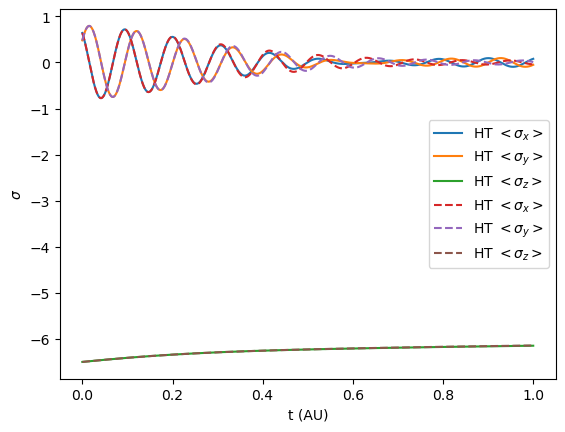

In [85]:
close("all")
figure()

plot(T, mean_σx_QC, label=L"HT $<\sigma_x>$", linestyle="-")
plot(T, mean_σy_QC, label=L"HT $<\sigma_y>$", linestyle="-")
plot(T, mean_σz67_QC, label=L"HT $<\sigma_z>$", linestyle="-")
plot(T, mean_σx, label=L"HT $<\sigma_x>$", linestyle="--")
plot(T, mean_σy, label=L"HT $<\sigma_y>$", linestyle="--")
plot(T, mean_σz, label=L"HT $<\sigma_z>$", linestyle="--")

xlabel("t (AU)")
ylabel(L"\sigma")
legend()

#pygui(true); show()
pygui(false); gcf()

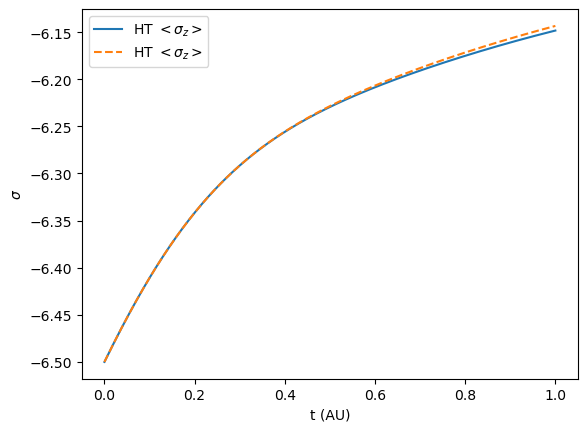

In [86]:
close("all")
figure()

plot(T, mean_σz67_QC, label=L"HT $<\sigma_z>$", linestyle="-")
plot(T, mean_σz, label=L"HT $<\sigma_z>$", linestyle="--")

xlabel("t (AU)")
ylabel(L"\sigma")
legend()

#pygui(true); show()
pygui(false); gcf()